# Distância euclidiana

Importando bibliotecas

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, lit, sqrt, sum as spark_sum, min as spark_min,  rank, exp, udf
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import DataFrame

Criando Sessão PySpark

In [8]:
spark = SparkSession.builder \
    .appName("Euclidean-Distance") \
    .getOrCreate()

Lendo dataframe de treino

In [9]:
parquet_path = "/home/jovyan/work/data/clean-data/train-data/creditcard_2023.parquet"

train_df = spark.read.parquet(parquet_path)

Lendo dataframe de teste

In [10]:
parquet_path = "/home/jovyan/work/data/clean-data/test-data/creditcard_2023.parquet"

test_df = spark.read.parquet(parquet_path)

Selecionando dados de treino

In [11]:
train_class_0 = train_df.filter(F.col("Class") == 0).limit(10000)
train_class_1 = train_df.filter(F.col("Class") == 1).limit(10000)
new_train_df = train_class_0.union(train_class_1)

In [12]:
new_train_df.count()

20000

In [13]:
new_train_df.groupBy("Class").count().orderBy("count", ascending=False).show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|10000|
|    1|10000|
+-----+-----+



Selecionando dados de teste

In [14]:
class_0 = test_df.filter(test_df.Class == 0).limit(500)
class_1 = test_df.filter(test_df.Class == 1).limit(500)

new_test_df = class_0.union(class_1)

In [15]:
new_test_df.groupBy("Class").count().orderBy("count", ascending=False).show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  500|
|    1|  500|
+-----+-----+



Quantidade de dados de treino

In [16]:
new_train_df.count()

20000

Quantidade de dados de teste

In [17]:
new_test_df.count()

1000

In [18]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def knn_predict(test_df, train_df, k):
    numeric_cols = [col for col in train_df.columns if col not in ['Class', 'Amount']]

    train_data = np.array(train_df.select(*numeric_cols).toPandas())
    train_labels = np.array(train_df.select('Class').toPandas()).flatten()

    test_data = np.array(test_df.select(*numeric_cols).toPandas())
    test_labels = np.array(test_df.select('Class').toPandas()).flatten()

    predictions = []

    for test_sample in test_data:
        distances = []
        for i, train_sample in enumerate(train_data):
            dist = euclidean_distance(test_sample, train_sample)
            distances.append((dist, train_labels[i]))

        k_nearest = sorted(distances, key=lambda x: x[0])[:k]
        
        classes = [label for _, label in k_nearest]
        predicted_class = max(set(classes), key=classes.count)

        predictions.append(predicted_class)

    accuracy = np.mean(np.array(predictions) == test_labels)
    print(f"Precisão: {accuracy:.2%}")
    return predictions, test_labels, accuracy

Testes

In [19]:
predictions, test_labels, accuracy = knn_predict(new_test_df, new_train_df, 1)

Precisão: 99.70%


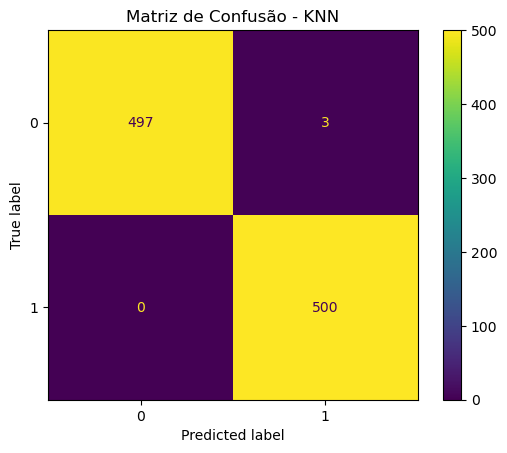

In [20]:
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - KNN")
plt.show()

In [21]:
predictions, test_labels, accuracy = knn_predict(new_test_df, new_train_df, 3)

Precisão: 99.30%


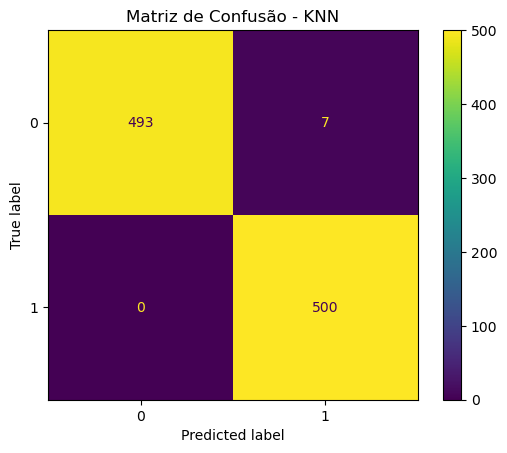

In [22]:
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - KNN")
plt.show()

In [23]:
predictions, test_labels, accuracy = knn_predict(new_test_df, new_train_df, 5)

Precisão: 99.10%


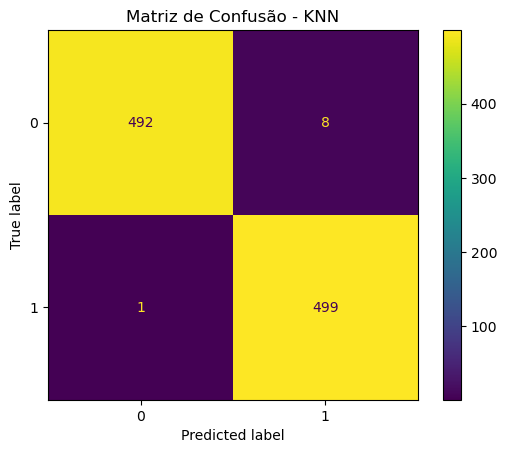

In [24]:
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - KNN")
plt.show()

In [25]:
predictions, test_labels, accuracy = knn_predict(new_test_df, new_train_df, 10)

Precisão: 99.20%


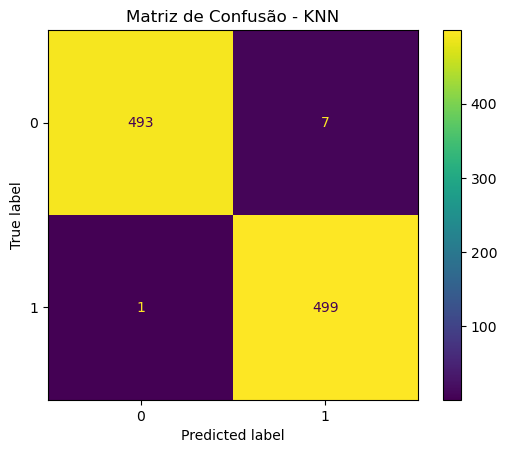

In [26]:
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - KNN")
plt.show()

Knn = 1
Precisão: 99.70%
Knn = 5
Precisão: 99.10%
Knn = 10
Precisão: 99.20%
Knn = 15
Precisão: 99.20%
Knn = 20
Precisão: 99.50%
Knn = 25
Precisão: 99.50%
Knn = 30
Precisão: 99.60%
Knn = 35
Precisão: 99.40%
Knn = 40
Precisão: 99.60%
Knn = 45
Precisão: 99.40%
Knn = 50
Precisão: 99.40%


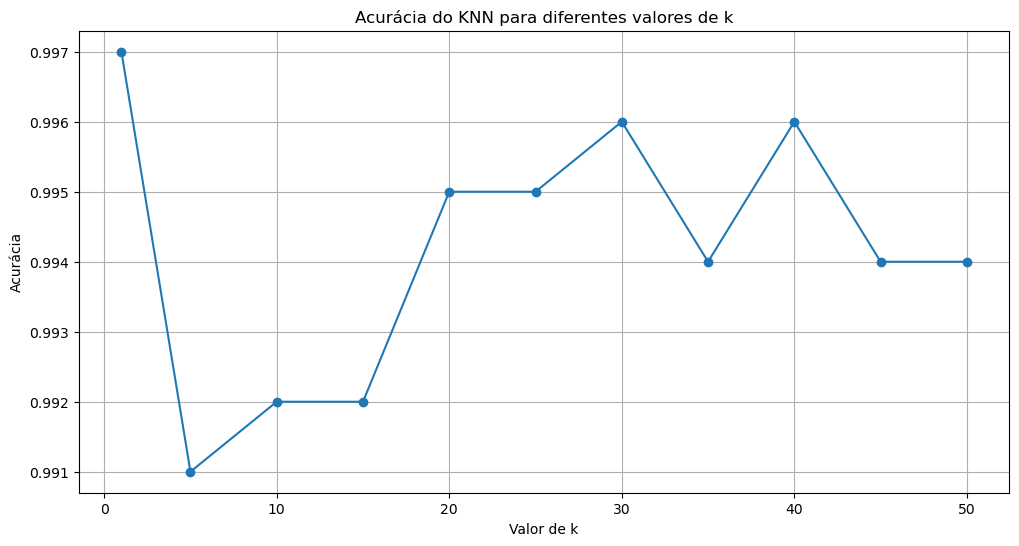

In [27]:
accuracies = []
k_values = [1] + list(range(5, 51, 5)) 

for k in k_values:
    print(f"Knn = {k}")
    predictions, test_labels, accuracy = knn_predict(new_test_df, new_train_df, k)
    accuracies.append(accuracy)

plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('Acurácia do KNN para diferentes valores de k')
plt.xlabel('Valor de k')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

Finalizando a sessão Spark

In [68]:
spark.stop()